In [3]:
!pip install transformers
!pip install accelerate -U
!pip install transformers[torch] -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 5.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.0
    Uninstalling transformers-4.44.0:
      Successfully uninstalled transformers-4.44.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments , AutoModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [5]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [6]:
# fpath = './data/'
# fpath+
balanced_df = pd.read_csv('/kaggle/input/sentiment-data/labeled_preprocessed_165k.csv')

In [7]:
balanced_df['label'].value_counts()

label
neutral     34405
sadness     33083
joy         28027
anger       27136
surprise    25243
disgust      9479
fear         8601
Name: count, dtype: int64

In [8]:
balanced_df

,Unnamed: 0.1,Unnamed: 0,text,label
0,12,12,contemplating giving iphone bandwagon simply c...,sadness
1,14,14,battery painful charge overnight lunchtime bat...,sadness
2,38,38,new iphone standing sir piously bad standing c...,sadness
3,58,58,having phone actually killing paying replacement,sadness
4,70,70,feeling broken phones screen replaced iphone h...,sadness
...,...,...,...,...
165969,282530,282530,veronica visit reel feed,neutral
165970,13487,13487,ave samsung mobile devices lam software galler...,neutral
165971,286805,286805,chicken pink,neutral
165972,161063,161063,ultimate pruning machine sta type bar blade sh...,neutral


In [9]:
balanced_df['label'].count()

165974

In [10]:
# Convert the 'text' column to strings
balanced_df['text'] = balanced_df['text'].astype(str)

In [11]:
texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

In [12]:

torch.cuda.is_available()


True

In [13]:
# Split the data into training and validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [14]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)

In [15]:
# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load the model and move it to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(set(labels))).to(device)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Tokenize the training and test texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# truncation - truncates the texts longer than max input length
# padding - pads texts shorter than the max length so that all texts are of same length

In [17]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [18]:
# Create PyTorch DataLoader for training and test data
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]).to(device),
    torch.tensor(train_encodings["attention_mask"]).to(device),
    torch.tensor(train_labels_encoded).to(device)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]).to(device),
    torch.tensor(test_encodings["attention_mask"]).to(device),
    torch.tensor(test_labels_encoded).to(device)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Shuffle reduces the risk of everfitting to the dataset pattern 

In [19]:
from tqdm import tqdm
# from transformers import AdamW
# import torch

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 3

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    # Wrap the train_loader with tqdm   
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for batch in pbar:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
               
            # Optionally, you can update the progress bar with additional information
            pbar.set_postfix({"loss": loss.item()})


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3: 100%|██████████| 8299/8299 [1:18:23<00:00,  1.76batch/s, loss=0.529] 


In [20]:
# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(labels.tolist())

# Calculate evaluation metrics               
print(classification_report(true_labels, predictions))     

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5418
           1       0.74      0.83      0.78      1825
           2       0.76      0.88      0.82      1740
           3       0.91      0.77      0.84      5709
           4       0.82      0.80      0.81      6911
           5       0.84      0.85      0.84      6493
           6       0.78      0.85      0.81      5099

    accuracy                           0.83     33195
   macro avg       0.82      0.83      0.82     33195
weighted avg       0.83      0.83      0.83     33195



In [21]:
model.save_pretrained("model")

In [22]:
tokenizer.save_pretrained("model")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.json',
 'model/merges.txt',
 'model/added_tokens.json')

In [24]:
model_load = RobertaForSequenceClassification.from_pretrained('model').to(device)

In [25]:
model_load.config

RobertaConfig {
  "_name_or_path": "model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "type_vocab_size": 

In [26]:
model_load.eval()
predictions_load, true_labels_load = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs_load = model_load(input_ids, attention_mask=attention_mask)
        logits_load = outputs_load.logits
        predictions_load.extend(torch.argmax(logits_load, dim=1).tolist())
        true_labels_load.extend(labels.tolist())

# Calculate evaluation metrics
print(classification_report(true_labels_load, predictions_load))     

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5418
           1       0.74      0.83      0.78      1825
           2       0.76      0.88      0.82      1740
           3       0.91      0.77      0.84      5709
           4       0.82      0.80      0.81      6911
           5       0.84      0.85      0.84      6493
           6       0.78      0.85      0.81      5099

    accuracy                           0.83     33195
   macro avg       0.82      0.83      0.82     33195
weighted avg       0.83      0.83      0.83     33195



In [28]:
model_load.eval()
predictions2, true_labels2 = [], []

with torch.no_grad():
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs_load = model_load(input_ids, attention_mask=attention_mask)
        logits_load = outputs_load.logits
        predictions2.extend(torch.argmax(logits_load, dim=1).tolist())
        true_labels2.extend(labels.tolist())

# Calculate evaluation metrics
print(classification_report(predictions2, true_labels2))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     21429
           1       0.95      0.87      0.91      8354
           2       0.97      0.86      0.91      7743
           3       0.87      0.98      0.92     19961
           4       0.91      0.93      0.92     27036
           5       0.94      0.93      0.94     26736
           6       0.95      0.89      0.92     21520

    accuracy                           0.93    132779
   macro avg       0.93      0.91      0.92    132779
weighted avg       0.93      0.93      0.93    132779



In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(true_labels2, predictions2)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[20329   549   278    23   134   303   102]
 [  152  7252   111     6    42    42    49]
 [   39    14  6627     4    25    40   112]
 [   89    22   122 19478  1118   296  1193]
 [  309   174   171   323 25145   780   592]
 [  381   295   359    33   138 24998   386]
 [  130    48    75    94   434   277 19086]]


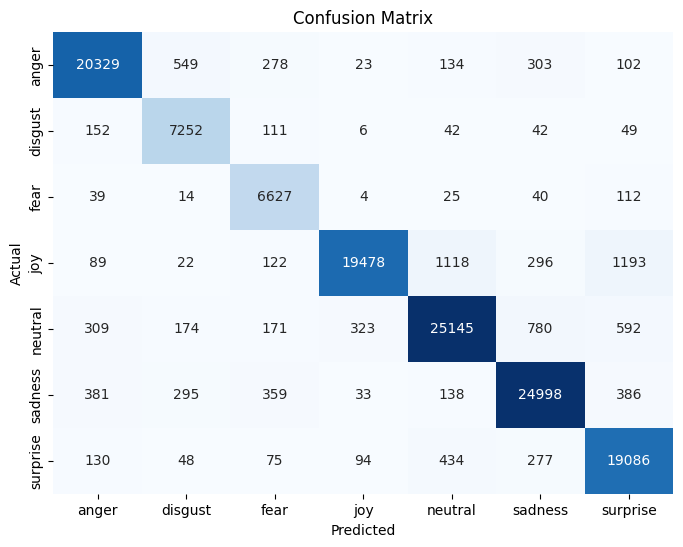

In [30]:
import seaborn as sns

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['anger', 'disgust', 'fear','joy','neutral','sadness','surprise'],
            yticklabels=['anger', 'disgust', 'fear','joy','neutral','sadness','surprise'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
!pip install wordcloud

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


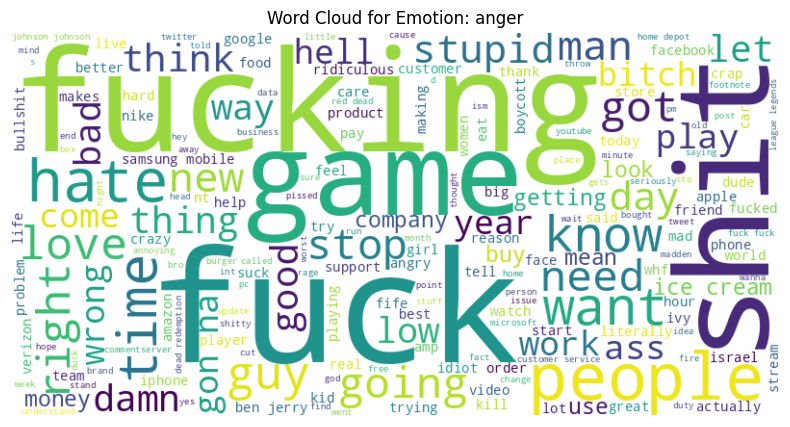

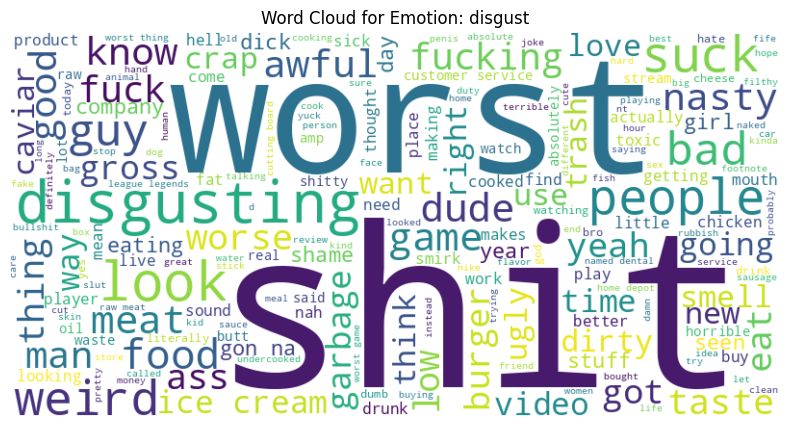

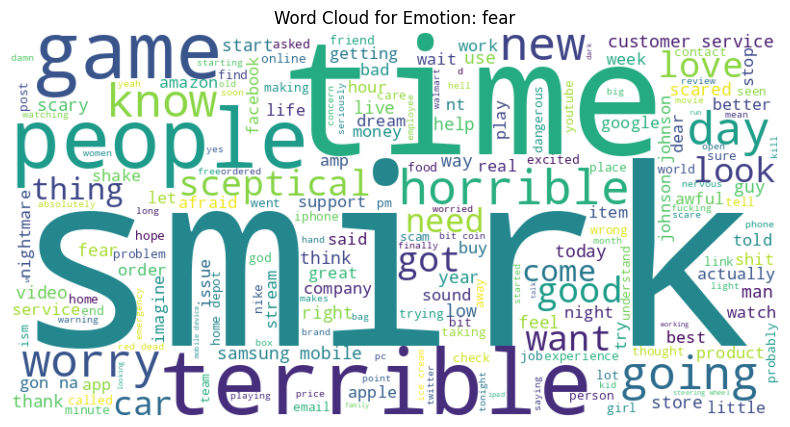

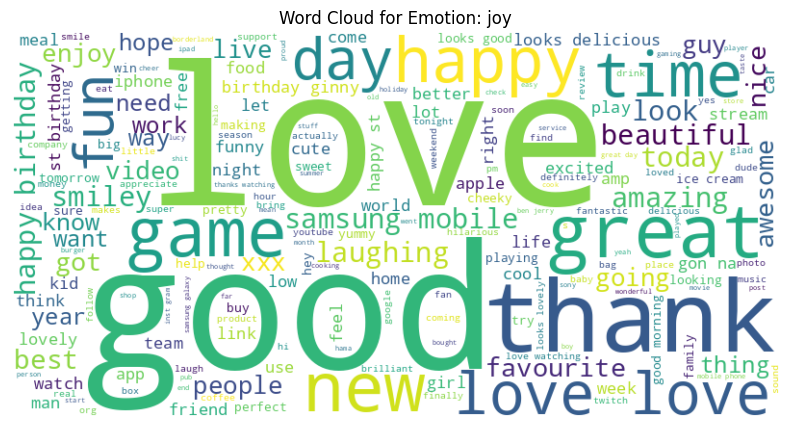

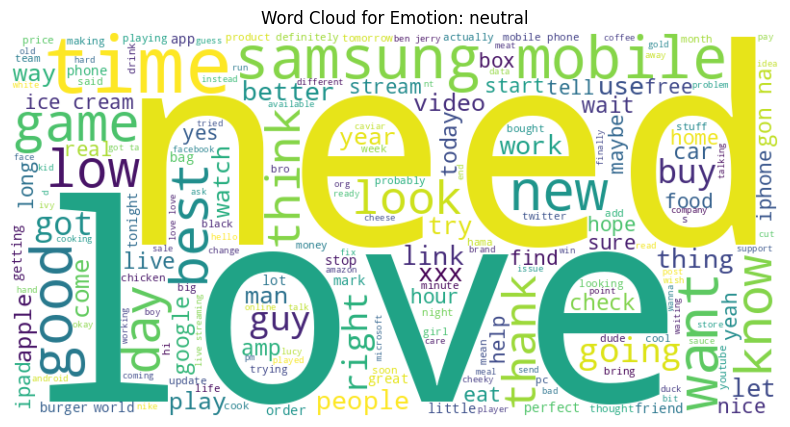

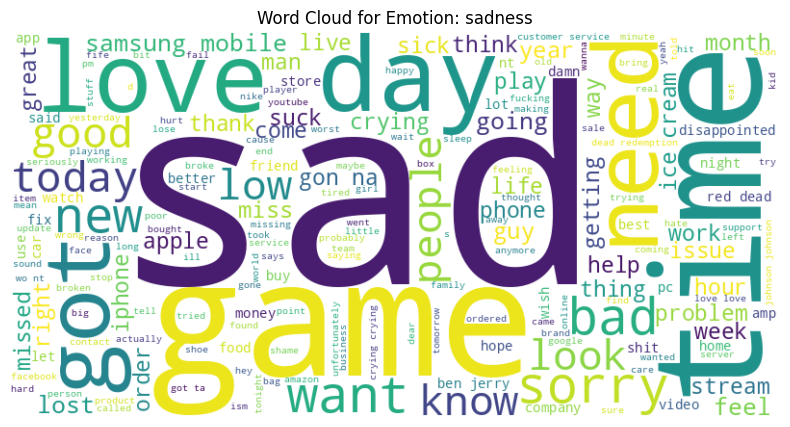

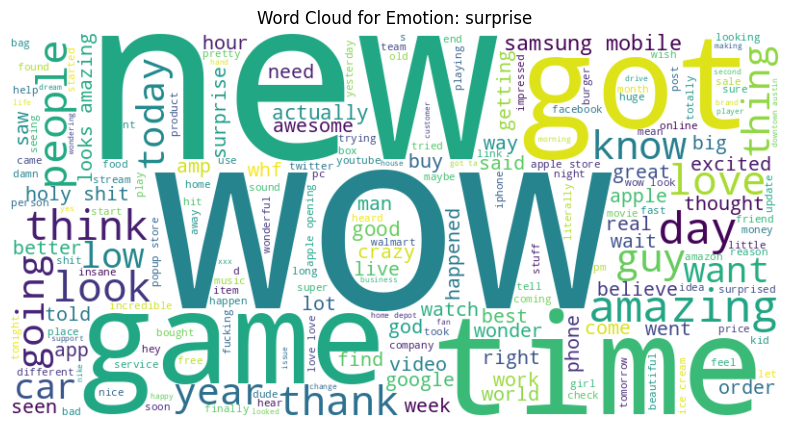

In [32]:
from wordcloud import WordCloud

# Define a function to generate word clouds for a given emotion class
def generate_word_cloud(clean_txt_data, emotion_class):
    # Combine all clean_txt data for the specified emotion class
    clean_txt = ' '.join(balanced_df[balanced_df['label'] == emotion_class]['text'])

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_txt)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Emotion: {emotion_class}')
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Call the function for each emotion class
emotion_classes = ['anger', 'disgust', 'fear','joy','neutral','sadness','surprise']

for emotion_class in emotion_classes:
    generate_word_cloud(balanced_df, emotion_class)


In [ ]:
# Code by - Jai Dixit